In [1]:
from tqdm.auto import tqdm
from pathlib import Path
import json, os, yaml

In [2]:
QA_dir  = Path("/mnt/g/G/RAG/outputs/QA_qwen.ndjson")
qa_list = []
with open(QA_dir, "r", encoding="utf-8") as f:
    for line in f:
        if line.strip():
            qa_list.append(json.loads(line))

In [3]:
import pandas as pd
keep_cols = ["rating_qwen_groundedness", "rating_qwen_relevance", "rating_qwen_standalone",
             "rating_gpt_groundedness", "rating_gpt_relevance", "rating_gpt_standalone"]
df = pd.DataFrame(qa_list)[keep_cols]
df = df.apply(pd.to_numeric, errors='coerce')

In [4]:
df.describe()

,rating_qwen_groundedness,rating_qwen_relevance,rating_qwen_standalone,rating_gpt_groundedness,rating_gpt_relevance,rating_gpt_standalone
count,497.000000,500.000000,496.000000,499.000000,493.000000,500.000000
mean,4.847082,2.298000,3.596774,4.849699,3.034483,3.854000
std,0.767771,1.558864,1.885272,0.757463,1.191445,1.748943
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,1.000000,1.000000,5.000000,2.000000,2.000000
50%,5.000000,2.000000,5.000000,5.000000,3.000000,5.000000
75%,5.000000,3.000000,5.000000,5.000000,4.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


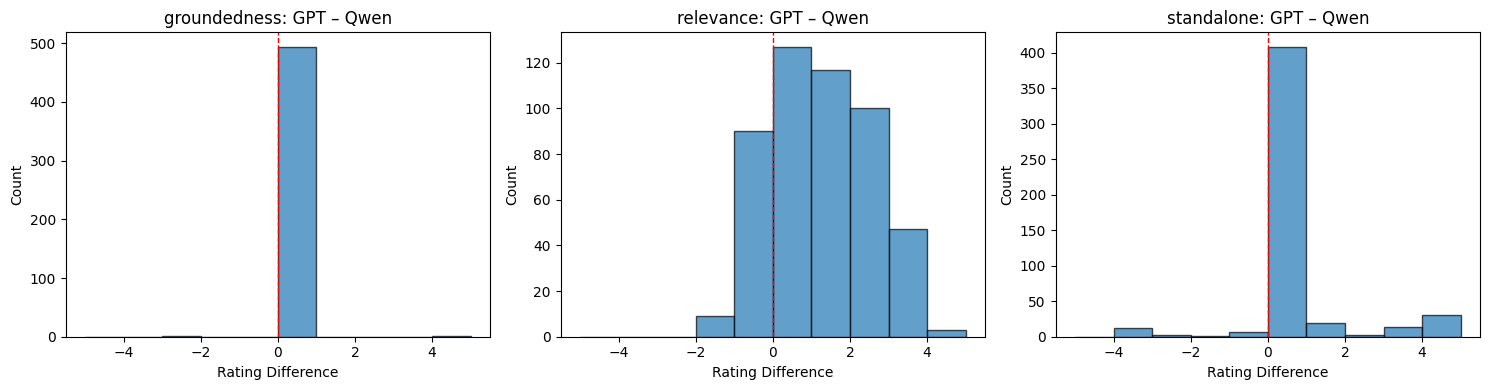

In [5]:
import matplotlib.pyplot as plt
categories = ["groundedness", "relevance" ,"standalone"]
plt.figure(figsize=(15, 4))  # one row, three plots
for i, cat in enumerate(categories, start=1):
    diff_col = f"diff_{cat}"
    gpt_col = f"rating_gpt_{cat}"
    qwen_col = f"rating_qwen_{cat}"

    # compute difference (GPT - Qwen)
    df[diff_col] = df[gpt_col] - df[qwen_col]

    # plot histogram
    plt.subplot(1, 3, i)
    plt.hist(df[diff_col], bins=range(-5, 6), edgecolor="black", alpha=0.7)
    plt.title(f"{cat}: GPT – Qwen")
    plt.xlabel("Rating Difference")
    plt.ylabel("Count")
    plt.axvline(0, color="red", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()

In [15]:
category = "standalone"
diff_thresh = 2

filtered = df[((df[f"rating_qwen_{category}"] - df[f"rating_gpt_{category}"]).abs() > diff_thresh)]
indices = filtered.index.tolist()
selected_records = [qa_list[i] for i in indices]
selected_records = [{"q": r['question'], "a": r['answer'], f'{category}_qwen': r[f'rating_qwen_{category}'], 
                     f'{category}_gpt': r[f"rating_gpt_{category}"]} for r in selected_records]
selected_records[0:3]
# sometimes gpt rating is better, sometimes qwen rating is better.
# for real project, one should dig into the rating, 
# and then tune the examples in prompt, to align with expert's ratings on the private data

[{'q': 'Who improved the Video Component in Gradio?',
  'a': '@hannahblair',
  'standalone_qwen': '1',
  'standalone_gpt': '5'},
 {'q': 'What command checks if the setup is ready for training?',
  'a': 'accelerate test',
  'standalone_qwen': '5',
  'standalone_gpt': '1'},
 {'q': 'What is the upload text displayed in the PDF upload component?',
  'a': 'Drop PDF',
  'standalone_qwen': '1',
  'standalone_gpt': '5'}]

In [1]:
# Requires transformers>=4.51.0

import torch
import torch.nn.functional as F

from torch import Tensor
from transformers import AutoTokenizer, AutoModel


def last_token_pool(last_hidden_states: Tensor,
                 attention_mask: Tensor) -> Tensor:
    left_padding = (attention_mask[:, -1].sum() == attention_mask.shape[0])
    if left_padding:
        return last_hidden_states[:, -1]
    else:
        sequence_lengths = attention_mask.sum(dim=1) - 1
        batch_size = last_hidden_states.shape[0]
        return last_hidden_states[torch.arange(batch_size, device=last_hidden_states.device), sequence_lengths]


def get_detailed_instruct(task_description: str, query: str) -> str:
    return f'Instruct: {task_description}\nQuery:{query}'

# Each query must come with a one-sentence instruction that describes the task
task = 'Given a web search query, retrieve relevant passages that answer the query'

queries = [
    get_detailed_instruct(task, 'What is the capital of China?'),
    get_detailed_instruct(task, 'Explain gravity')
]
# No need to add instruction for retrieval documents
documents = [
    "The capital of China is Beijing.",
    "Gravity is a force that attracts two bodies towards each other. It gives weight to physical objects and is responsible for the movement of planets around the sun."
]
input_texts = queries + documents

tokenizer = AutoTokenizer.from_pretrained('Qwen/Qwen3-Embedding-0.6B', padding_side='left')
model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B')

# We recommend enabling flash_attention_2 for better acceleration and memory saving.
# model = AutoModel.from_pretrained('Qwen/Qwen3-Embedding-0.6B', attn_implementation="flash_attention_2", torch_dtype=torch.float16).cuda()

max_length = 8192

# Tokenize the input texts
batch_dict = tokenizer(
    input_texts,
    padding=True,
    truncation=True,
    max_length=max_length,
    return_tensors="pt",
)
batch_dict.to(model.device)
outputs = model(**batch_dict)
embeddings = last_token_pool(outputs.last_hidden_state, batch_dict['attention_mask']).detach()

# normalize embeddings
embeddings = F.normalize(embeddings, p=2, dim=1)
scores = (embeddings[:2] @ embeddings[2:].T)
print(scores.tolist())
# [[0.7645568251609802, 0.14142508804798126], [0.13549736142158508, 0.5999549627304077]]


[[0.7645566463470459, 0.1414250135421753], [0.1354975402355194, 0.599955141544342]]


In [9]:
import faiss
dim = embeddings.shape[1]
base_index  = faiss.IndexFlatIP(dim)  # Inner product for cosine similarity
index = faiss.IndexIDMap(base_index)       # allows mapping IDs → vectors
# Add only the document embeddings (for retrieval)
doc_ids = [100+i for i in range(len(queries))]
index.add_with_ids(embeddings[len(queries):].numpy(), torch.tensor(doc_ids, dtype=torch.int64).numpy())

print(f"Added {index.ntotal} document vectors to FAISS index")

# ----------------------------
# Step 3: Search with queries
# ----------------------------
query_embs = embeddings[:len(queries)].numpy()
k = 2  # top-k results
scores, ids = index.search(query_embs, k)

Added 2 document vectors to FAISS index


In [10]:
scores

array([[0.7645566 , 0.14142501],
       [0.59995514, 0.13549754]], dtype=float32)

In [11]:
index.id_map


<faiss.swigfaiss_avx512.Int64Vector; proxy of <Swig Object of type 'std::vector< long > *' at 0x7e9777376f70> >

In [12]:
ids

array([[100, 101],
       [101, 100]])